In [1]:
from modular_entanglement import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

This notebook is intended to provide all the necessary code to make plots like Figure 8 from "Unitary Entanglement Construction in Hierarchical Networks," Bapat et al 2018. All functions called are stored in a file called modular_entanglement.py, which should have been distributed with this notebook. Contact Zachary Eldredge at eldredge@umd.edu with any questions

The purpose of this notebook is to create two types of graph, hierarchies and grid graphs, and then to perform a simulation of GHZ state creation on those graphs using probabilistic unitaries. At each time step, there is some probability that our graph will be able to perform a two-node gate that extends the GHZ state. We continue this until the GHZ state covers every node.

This notebook is prepared to allow for the reproduction of our figure. You are free to use our code in more general ways; the key function (found in modular_entanglement.py) is probably nx_color_spread, which simulates the spread of the GHZ state. It is named color_spread because internally we keep track of which nodes have been entangled with the original node by coloring the node.

# Simulation Parameters

At this point, we establish the parameters which will be used going forward.

hier_base: The base graph used to construct the hierarchical product. As a default we have chosen $K_3$. Refer to the documentation for the NetworkX package for construction of other graphs.

alpha_list: The list of scaling parameters $\alpha$ to be used in the weighted hierarchical product. The scaling parameter $\alpha$ controls how quickly the probability of succeess decreases for higher-order edges.

level_list: We present in the paper the definition of a hierarchy with a number of levels $i$. This list is every level $i$ that the program will generate $G^{\Pi i}$ and run a probabilistic simulation of GHZ state creation on.

ntrials: The number of trials to run in order to accumulate statistics.

p0: The "base probability"; the probability that in one time-step an edge with unit weight succeeds in performing a unitary operation.

In [2]:
hier_base = nx.complete_graph(3) # This is the base graph used to construct the hierarchical product. As a defult
unit_size = len(hier_base) # Order of the base graph
alpha_list = [2/3,1/2,1/3] # Alpha-scalings to try
level_list = [1,2,3,4,5,6] # All sizes of hierarchies we will use
nqlist = [unit_size**x for x in level_list] # Useful for later -- a list of how many qubits are in each test graph
ntrials = 10 # Number of trials to run
p0 = .1 #Base probability

## Hierarchy Results

This piece of code creates two arrays ($\mathrm{hier\_results}$ and $\mathrm{hier\_fits}$). Both store, in element $[i][j]$, the expected time for GHZ state creation to complete with a scaling parameter given by $\mathrm{alpha\_list}[i]$ and a number of levels given by $\mathrm{level\_list}[j]$.

We accomplish this by using a function, $\mathrm{build\_weighted\_hierarchical}$, which constructs a NetworkX Graph object that corresponds to our $G^{\Pi i}$ hierarchy. As its last argument, it takes an arbitrary function which is used to produce the scaling -- the weighted hierarchy we outline in our paper corresponds to choosing a function that scales geometrically with $x$ (the level of the hierarchy). A function called $\mathrm{run\_trials}$ then performs $\mathrm{ntrials}$ trials of the spread of the GHZ state out from a specified initial node.

Note that by passing a different function as the last argument to $\mathrm{build\_weighted\_hierarchical}$, hierarchies which have arbitrary scaling functions can be created.

We also use a function, $\mathrm{hier\_fit\_fn}$, which computes the weighted diameter of the graph $G^{\Pi i}$, note that it is assumed that the scaling function is geometric.

In [3]:
hier_results = np.zeros((len(alpha_list), len(level_list))) # Build the empty arrays to store restults in
hier_fits = np.zeros((len(alpha_list), len(level_list)))

for i, alpha in enumerate(alpha_list): # Loop over different scaling parameters
    for j, nlevels in enumerate(level_list): # Loop over different size heirarchies
        init_pt = tuple([unit_size-1]*nlevels) # We must choose an initial point for the GHZ state to come from
                                               # this point is, according to our addressal scheme, at the bottom
        
        #Build the weighted hierarchy
        hier_scaling = build_weighted_hierarchical(hier_base, nlevels, lambda x: p0*(alpha**x))
        
        #Run trials, store the results in hier_results
        hier_results[i,j] = run_trials(hier_scaling,ntrials,init_pt, maxtsteps = 10**5)
        
        #Also produce the fits predicted by weighted diameter
        hier_fits[i,j] = hier_fit_fn(nqlist[j], alpha, unit_size)/p0

We will now visualize the results of the above cell by plotting lines in which every point shows the results for a different number of qubits, at an $\alpha$ common to every point on the line. For flexibility purposes, the plot produced will not be as polished as the one which appeared in our paper.

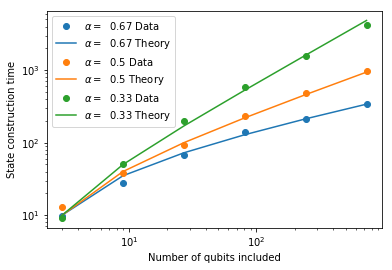

In [4]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
        'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'] # List of colors
for i,a in enumerate(alpha_list): # For every alpha, plot the analytic and the numerical results
    plt.loglog(nqlist, hier_results[i][:], marker = 'o', linestyle = 'none', label = r'$\alpha =$  {0:.2} Data'.format(a), color = colors[i])
    plt.loglog(nqlist, hier_fits[i][:], label = r'$\alpha = $  {0:.2} Theory'.format(a), color = colors[i])
plt.xlabel('Number of qubits included')
plt.ylabel('State construction time')

plt.legend()

## Square Grid Results

This works in essentially the same way as the hierarchical results. A NetworkX built-in, grid_2d_graph(), is use to construct the graph, and then every edge is given weight p0. 

In [5]:
sq_size_list = [2,4,5,10,15,20,25] # For every of these i, we build a graph of size i x i
nn_fit = 1/p0 * np.array([nn_fit_fn(x**2) for x in sq_size_list]) # The fit function (which will be wrong -- see paper)
nn_results = [] # Results array
for sq in sq_size_list: # For every size of square grid
    init_pt = (0,0) # Start in one corner
    nn = nx.grid_2d_graph(sq, sq) # Build the graph
    for i,j in nn.edges(): # Re-weight all the edges
        nn[i][j]['weight'] = p0
    nn_results.append(run_trials(nn,ntrials,init_pt)) # Run the experiment

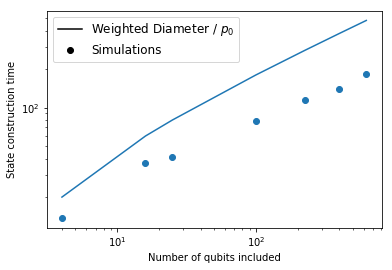

In [6]:
plt.loglog([s**2 for s in sq_size_list],nn_fit)
plt.loglog([s**2 for s in sq_size_list],nn_results, linestyle = 'none', marker = 'o', color = 'tab:blue')
line = mlines.Line2D([], [], color='black', label=r'Weighted Diameter / $p_0$')
marker = mlines.Line2D([], [], marker='o', color = 'black', label='Simulations', linewidth = 0)
plt.legend(handles=[line, marker], fontsize = 12)

plt.xlabel('Number of qubits included')
plt.ylabel('State construction time')